In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import pickle
from sklearn.inspection import permutation_importance

In [3]:
# Data filepath
f = "../data/"

In [4]:
full_df = pd.read_csv(f+"final_cohort.csv")
# Note: target is hospital_expire_flag

In [5]:
full_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'long_title', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admit_provider_id', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'stay_id', 'first_careunit',
       'last_careunit', 'intime', 'outtime', 'los', 'Absolute Basophil Count',
       'Absolute Eosinophil Count', 'Absolute Lymphocyte Count',
       'Absolute Monocyte Count', 'Absolute Neutrophil Count',
       'Alanine Aminotransferase (ALT)', 'Albumin', 'Alkaline Phosphatase',
       'Anion Gap', 'Asparate Aminotransferase (AST)', 'Base Excess',
       'Basophils', 'Bicarbonate', 'Bilirubin, Total', 'CK-MB Index',
       'Calculated Total CO2', 'Cholesterol Ratio (Total/HDL)',
       'Cholesterol, HDL', 'Cholesterol, Total', 'Creatine Kinase (CK)',
  

In [6]:
# Removing features that are not important to model or redundant
df = full_df.copy().drop(
    ['hadm_id', 'dod', 'seq_num', 'icd_code', 'icd_version', 'long_title', 
     'admittime', 'dischtime', 'discharge_location', 'edregtime', 'edouttime', 
     'stay_id', 'outtime','anchor_year', 'anchor_year_group', 'Hematocrit, Calculated',
     'RDW-SD', 'Basophils', 'Eosinophils', 'Monocytes', 'Lymphocytes', 'CK-MB Index', 
     'Oxygen'], 
    axis=1
    )

# Calculating survival time
df['intime'] = pd.to_datetime(df['intime'])
df['deathtime'] = pd.to_datetime(df['deathtime'])

df['survival_time'] = (df['deathtime'] - df['intime']).dt.total_seconds() / (60 * 60 * 24)
df['90_day_mortality'] = (df['survival_time']<=90).astype(int)
df['30_day_mortality'] = (df['survival_time']<=30).astype(int)

# Keep only rows with SIRI
df = df[
    df["SIRI"].notna()
    & df["Absolute Neutrophil Count"].notna()
    & df["Absolute Monocyte Count"].notna()
    & df["Absolute Lymphocyte Count"].notna()
].copy()

In [7]:
y = df['30_day_mortality']
X = df.copy().drop(['subject_id','hospital_expire_flag', 'intime', 'deathtime', '90_day_mortality', '30_day_mortality'], axis=1)

In [8]:
X.columns

Index(['admission_type', 'admit_provider_id', 'admission_location',
       'insurance', 'language', 'marital_status', 'race', 'gender',
       'anchor_age', 'first_careunit', 'last_careunit', 'los',
       'Absolute Basophil Count', 'Absolute Eosinophil Count',
       'Absolute Lymphocyte Count', 'Absolute Monocyte Count',
       'Absolute Neutrophil Count', 'Alanine Aminotransferase (ALT)',
       'Albumin', 'Alkaline Phosphatase', 'Anion Gap',
       'Asparate Aminotransferase (AST)', 'Base Excess', 'Bicarbonate',
       'Bilirubin, Total', 'Calculated Total CO2',
       'Cholesterol Ratio (Total/HDL)', 'Cholesterol, HDL',
       'Cholesterol, Total', 'Creatine Kinase (CK)',
       'Creatine Kinase, MB Isoenzyme', 'Creatinine', 'Fibrinogen, Functional',
       'H', 'Hematocrit', 'Hemoglobin', 'I', 'INR(PT)',
       'Immature Granulocytes', 'Ketone', 'L', 'Lactate',
       'Lactate Dehydrogenase (LD)', 'Oxygen Saturation', 'PT', 'PTT',
       'Platelet Count', 'Protein', 'RDW', 'Red B

In [9]:
# Missing values
pd.set_option('display.max_rows', 10)  

X_nan_number = X.isna().sum().sort_values(ascending=False)
X_nan_percentage = X_nan_number/X.shape[0]

missing_rows = X[X.isnull()]
print(f"Number of rows with missing values (max: {X.shape[0]}): {missing_rows.shape}") # Every row has missing values

pd.set_option('display.max_rows', None)
X_nan_percentage[X_nan_percentage>0.2]

Number of rows with missing values (max: 2379): (2379, 58)


Ketone                             0.957966
Cholesterol Ratio (Total/HDL)      0.892392
Cholesterol, HDL                   0.890290
Cholesterol, Total                 0.889029
Triglycerides                      0.847835
Protein                            0.823876
survival_time                      0.820092
Temperature                        0.807482
Specific Gravity                   0.765448
Creatine Kinase (CK)               0.693148
Albumin                            0.604876
Lactate Dehydrogenase (LD)         0.564523
Creatine Kinase, MB Isoenzyme      0.511139
Troponin T                         0.478352
Fibrinogen, Functional             0.445565
Bilirubin, Total                   0.419504
Alanine Aminotransferase (ALT)     0.417402
Alkaline Phosphatase               0.416982
Oxygen Saturation                  0.412778
Asparate Aminotransferase (AST)    0.411097
dtype: float64

In [10]:
# Removing columns with greater than 20% missing values
nan_cols = (X_nan_percentage[X_nan_percentage>0.2].index)
X = X.drop(nan_cols, axis=1)

**ORGANIZING DATA**

In [11]:
X.columns

Index(['admission_type', 'admit_provider_id', 'admission_location',
       'insurance', 'language', 'marital_status', 'race', 'gender',
       'anchor_age', 'first_careunit', 'last_careunit', 'los',
       'Absolute Basophil Count', 'Absolute Eosinophil Count',
       'Absolute Lymphocyte Count', 'Absolute Monocyte Count',
       'Absolute Neutrophil Count', 'Anion Gap', 'Base Excess', 'Bicarbonate',
       'Calculated Total CO2', 'Creatinine', 'H', 'Hematocrit', 'Hemoglobin',
       'I', 'INR(PT)', 'Immature Granulocytes', 'L', 'Lactate', 'PT', 'PTT',
       'Platelet Count', 'RDW', 'Red Blood Cells', 'SIRI', 'Urea Nitrogen',
       'pO2'],
      dtype='object')

In [12]:
names_cat_feats = ['admission_type', 'admit_provider_id', 'admission_location',
       'insurance', 'language', 'marital_status', 'race', 'gender', 'first_careunit', 
       'last_careunit']
names_cont_feats = ['anchor_age', 'los',
       'Absolute Basophil Count', 'Absolute Eosinophil Count',
       'Absolute Lymphocyte Count', 'Absolute Monocyte Count',
       'Absolute Neutrophil Count', 'Anion Gap', 'Base Excess', 'Bicarbonate',
       'Calculated Total CO2', 'Creatinine', 'H', 'Hematocrit', 'Hemoglobin',
       'I', 'INR(PT)', 'Immature Granulocytes', 'L', 'Lactate', 'PT', 'PTT',
       'Platelet Count', 'RDW', 'Red Blood Cells', 'SIRI', 'Urea Nitrogen',
       'pO2']

**SPLITTING & PREPROCESSING DATA (JUST FOR EDA)**

In [13]:
print(f"balance (percentage): {y.value_counts()/(len(y))}") # Data is imbalanced

X_train, X_val, y_train, y_val = train_test_split( #80-20 train-val split
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

balance (percentage): 30_day_mortality
0    0.836906
1    0.163094
Name: count, dtype: float64


In [14]:
''' 
Creating and collecting encoders
- For categorical data, treat missing data as its own category
- Will be done in pipeline again, but this is done to prepare for feature comparisons
'''
from sklearn.impute import SimpleImputer

onehot_ftrs = names_cat_feats
std_ftrs = names_cont_feats

# Categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs)
    ]
)

clf = Pipeline(steps=[('preprocessor', preprocessor)])
final_scaler = StandardScaler()

In [15]:
# Fit and transform
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)

# Standard scale
X_train_prep = final_scaler.fit_transform(X_train_prep)
X_val_prep = final_scaler.transform(X_val_prep)

# Turn into dfs
X_train_df = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
X_val_df = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())

In [16]:
# Pearson Correlations

mat = X_train_df.corr(method='pearson', min_periods=1, numeric_only=False)

# Set a threshhold for correlation values
threshold = 0.8

# Get the pairs of features that meet the criteria
mask = (mat > threshold) & (mat != 1)  # Exclude self-correlation
high_corr_pairs = mat[mask]

# Convert to a long format for easier reading
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Get rid of reverse-order pairs of (Feature1, Feature2)
high_corr_pairs['Sorted_Pair'] = high_corr_pairs.apply(
    lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)

high_corr_pairs_unique = high_corr_pairs.drop_duplicates(subset='Sorted_Pair')
high_corr_pairs_unique = high_corr_pairs_unique.drop(columns=['Sorted_Pair'])

sorted_pairs = high_corr_pairs_unique.sort_values(by='Correlation', ascending=False)

# Display the sorted DataFrame with descriptions
print(sorted_pairs)

                  Feature1                        Feature2  Correlation
10            std__INR(PT)                         std__PT     0.985752
6          std__Hematocrit                 std__Hemoglobin     0.965628
7          std__Hematocrit            std__Red Blood Cells     0.945693
1         std__Base Excess       std__Calculated Total CO2     0.915790
9          std__Hemoglobin            std__Red Blood Cells     0.914900
3         std__Bicarbonate       std__Calculated Total CO2     0.851939
0         std__Base Excess                std__Bicarbonate     0.833361
14               std__SIRI  ohot__admit_provider_id_P647R8     0.824278
16  ohot__language_Russian      ohot__race_WHITE - RUSSIAN     0.822566


In [17]:
# Features to be dropped: [Hematocrit, PT, Calculated Total CO2]
X = X.drop(['Hematocrit', 'PT', 'Calculated Total CO2'], axis=1)
X_train_df = X_train_df.drop(['std__Hematocrit', 'std__PT', 'std__Calculated Total CO2'], axis=1)

338.86308020239784


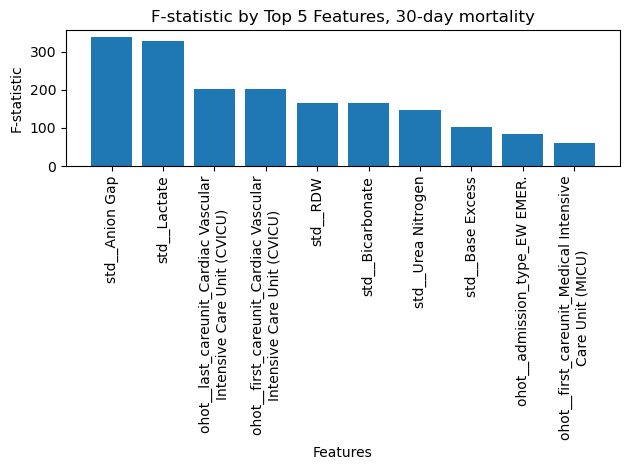

In [28]:
# F-tests
from sklearn.feature_selection import f_classif, mutual_info_classif

X_filt = X_train_df.copy().fillna(-1, inplace=False) # Sloppy but just for EDA because filling continuous nans with -1

f_stats, p_values = f_classif(X_filt, y_train)
lin_corr = pd.Series(f_stats, index = X_filt.columns).sort_values(ascending=False)

Xf = lin_corr.head(10).index
Yf = lin_corr.head(10).values
print(max(Yf))

import textwrap
labels_wrapped = [textwrap.fill(label, 40) for label in Xf]

plt.bar(labels_wrapped, Yf)
figsize = (4,3)
plt.title(f'F-statistic by Top 5 Features, 30-day mortality')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

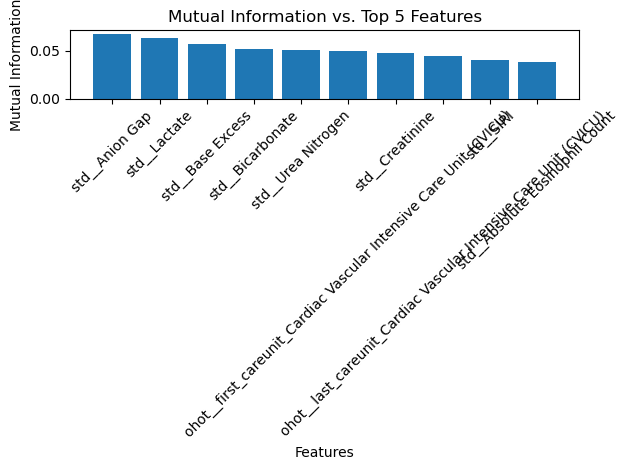

In [29]:
# MI Test for Non-Linear Correlations
mc = mutual_info_classif(X_filt, y_train)
non_lin_corr = pd.Series(mc, X_filt.columns).sort_values(ascending=False)

Xm = non_lin_corr.head(10).index
Ym = non_lin_corr.head(10).values

plt.bar(Xm, Ym)
figsize=(4,3)
plt.title(f'Mutual Information vs. Top 5 Features')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

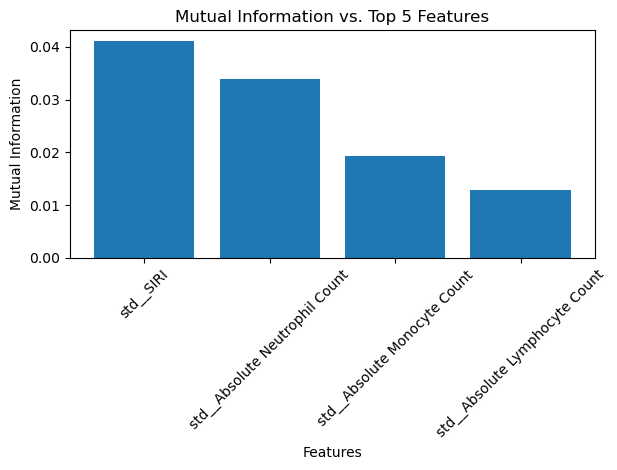

In [30]:
# Exploring SIRI vs target
X_immune = X_filt[["std__Absolute Lymphocyte Count", "std__Absolute Monocyte Count", "std__Absolute Neutrophil Count", "std__SIRI"]]
mc = mutual_info_classif(X_immune, y_train)
non_lin_corr = pd.Series(mc, X_immune.columns).sort_values(ascending=False)

Xm = non_lin_corr.head(10).index
Ym = non_lin_corr.head(10).values

plt.bar(Xm, Ym)
figsize=(4,3)
plt.title(f'Mutual Information vs. Top 5 Features')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

[34.53112999 47.30192939 49.81885812 51.07073006 51.82185322]
51.90531134413965


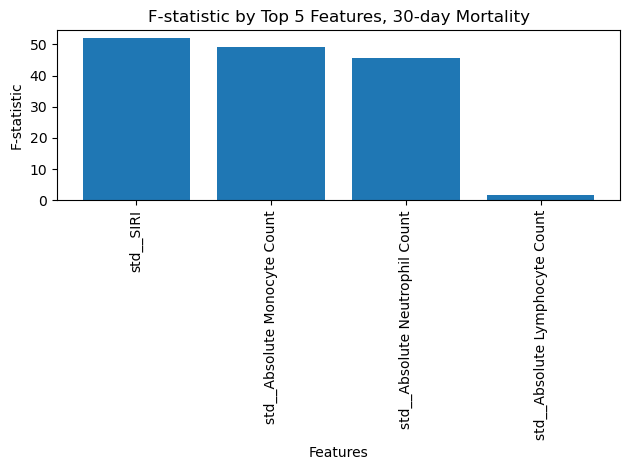

In [32]:
f_stats, p_values = f_classif(X_immune, y_train)
print(np.percentile(f_stats, [25, 50, 75, 90, 99]))
lin_corr = pd.Series(f_stats, index = X_immune.columns).sort_values(ascending=False)

Xf = lin_corr.head(10).index
Yf = lin_corr.head(10).values
print(max(Yf))

import textwrap
labels_wrapped = [textwrap.fill(label, 40) for label in Xf]

plt.bar(labels_wrapped, Yf)
figsize = (4,3)
plt.title(f'F-statistic by Top 5 Features, 30-day Mortality')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

**EXPORTING PREPROCESSED CSV**

In [81]:
df_preprocessed = X.copy()
df_preprocessed['target'] = y  

# Export to CSV
df_preprocessed.to_csv(f+'30_day_mort.csv', index=False)